# Setup

In [1]:
import dspy

from dotenv import load_dotenv
load_dotenv()

True

In [36]:
# print(gpt35_turbo.inspect_history(1))
dspy.configure

<bound method Settings.configure of {'lm': <dsp.modules.gpt3.GPT3 object at 0x15f785450>, 'rm': None, 'branch_idx': 0, 'reranker': None, 'compiled_lm': None, 'force_reuse_cached_compilation': False, 'compiling': False, 'skip_logprobs': False, 'trace': None, 'release': 0, 'log_openai_usage': False, 'bypass_assert': False, 'bypass_suggest': False, 'assert_failures': 0, 'suggest_failures': 0, 'langchain_history': []}>

# DSPy playground

DSPy consists of two different concepts brought together:
- DSPy programming language
- DSPy compiler

The DSPy programming language focus on organizing LMs as building blocks to create a more complex system. Here, LMs are treated as layers in a neural network, while their prompts are the weights.
> In this context, different prompting techniques are seen as different layers: Predict (zero-shot), ChainOfThought, React, and so on.

The DSPy compiler is a tool to optimize the DSPy program. The compiler uses a DSPy program, a training set, and a metric to optimize the program following a teleprompt (an optimizer)

Therefore, the parallel follows:

| DSPy              | PyTorch                   |
| :--------:        | :-------:                 |
| LMs               | Layers                    |
| LM prompts        | Layers' weights           |
| Teleprompters     | Optimizer                 |
| Compiling         | Training                  |
| Bootstraping      | Hyperparameters tuning    |


Hands-on!

Despite DSPy's architecture, we can still call LMs directly

In [2]:
gpt35_turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct')
# gpt35_turbo = dspy.OpenAI(model='gpt-3.5-turbo-1106', model_type="text")
dspy.settings.configure(lm=gpt35_turbo)

In [3]:
config = {
    'n' : 5,
    'max_tokens' : 250,
    'temperature' : 0.5,
}
h = f"{40*'-'} Output {40*'-'}"
print(f"{h}\n"
      f"{gpt35_turbo('Using DSPy, can I just call LM models directly?', **config)}"
      f"\n{len(h)*'-'}\n"
      )


---------------------------------------- Output ----------------------------------------
['\n\nYes, you can call LM (linear model) models directly in DSPy using the LinearModel class. This class allows you to create and manipulate linear models, including fitting them to data, making predictions, and evaluating model performance.', '\n\nNo, DSPy does not have the capability to directly call LM models. DSPy is a library for digital signal processing and does not have any specific functionality for LM models. However, you can use DSPy to preprocess data and then use a separate library or tool to call LM models.', '\n\nNo, DSPy does not have a direct interface for calling LM models. It is designed to be used for building and training neural networks, not for directly calling pre-trained models. However, DSPy does have the ability to load and use pre-trained models as part of the network architecture, so you could use it in that way if you have a pre-trained LM model that you want to incor

Of course, we dont need DSPy for that. DSPy strength comes from wrapping LMs in programming modules (layers) that can be assambled to create programs (models)

In [10]:
pred = dspy.Predict('question -> answer', **config)

h = f"{40*'-'} Predict output {40*'-'}"
print(f"{h}\n"
      f"{pred(question = 'What is the capital of France?').completions.answer}"
      f"\n{len(h)*'-'}\n"
      )

CoT = dspy.ChainOfThought('question -> answer', **config)
h = f"{35*'-'} Chain of Thoughts output {35*'-'}"
print(f"{h}\n"
      f"{CoT(question = 'What is the capital of France?').completions.answer}"
      f"\n{len(h)*'-'}"
      )

---------------------------------------- Predict output ----------------------------------------
['Paris', 'Paris']
------------------------------------------------------------------------------------------------

----------------------------------- Chain of Thoughts output -----------------------------------
['The capital of France is Paris.', 'Paris']
------------------------------------------------------------------------------------------------


In [9]:
gpt35_turbo.inspect_history(n=1)





Given the fields `question`, produce the fields `answer`.

---

Follow the following format.

Question: ${question}
Answer: ${answer}

---

Question: The average score on last week's Spanish test was 90. Marco scored 10% less than the average test score and Margaret received 5 more points than Marco. What score did Margaret receive on her test?
Answer: 86

---

Question: Bridget counted 14 shooting stars in the night sky. Reginald counted two fewer shooting stars than did Bridget, but Sam counted four more shooting stars than did Reginald. How many more shooting stars did Sam count in the night sky than was the average number of shooting stars observed for the three of them?
Answer: 2

---

Question: Sarah buys 20 pencils on Monday. Then she buys 18 more pencils on Tuesday. On Wednesday she buys triple the number of pencils she did on Tuesday. How many pencils does she have?
Answer: 92

---

Question: The result from the 40-item Statistics exam Marion and Ella took already came out

But how do we know which LM are `dspy.Predict` and `dspy.ChainOfThought using`? 

Annoyingly, DSPy takes the LM from its configuration (`dspy.settings.configure(lm=gpt35_turbo)`), not from the modules. 

But there's a workaround: `dspy.context`.

In [4]:
gpt4_turbo = dspy.OpenAI(model='gpt-4-1106-preview')

with dspy.context(lm=gpt4_turbo):
  config = {
      'n' : 2,
      'max_tokens' : 250,
      'temperature' : 0.5,
  }
  pred = dspy.Predict('question -> answer', **config)

  h = f"{40*'-'} Predict output {40*'-'}"
  print(f"{h}\n"
        f"{pred(question = 'What is the capital of France?').completions.answer}"
        f"\n{len(h)*'-'}\n"
        )

---------------------------------------- Predict output ----------------------------------------
['Question: What is the capital of France?\nAnswer: The capital of France is Paris.', 'Question: What is the capital of France?\nAnswer: The capital of France is Paris.']
------------------------------------------------------------------------------------------------



DSPy supports a few remote LMs:
- OpenAI
- AzureOpenAI
- Cohere
- Anyscale
- Together
- Databricks
- Mistral
- dspy.AWSMistral
- dspy.AWSAnthropic
- dspy.AWSMeta
- ...

But we can also use local LMs using a local server with:
- HFClientTGI
- HFClientVLLM
- HFModel

# Reproducing DSPy

## GSM8K dataset

In [11]:
from dspy.datasets.gsm8k import GSM8K, gsm8k_metric
from dspy.teleprompt import (
    LabeledFewShot,
    BootstrapFewShotWithRandomSearch,
    Ensemble
)
from dspy.evaluate import Evaluate

gpt35_turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct')
dspy.settings.configure(lm=gpt35_turbo)

In [14]:
gsm8k = GSM8K()
gsm8k_trainset, gsm8k_devset = gsm8k.train[:10], gsm8k.dev[:10]

100%|██████████| 1319/1319 [00:00<00:00, 70845.01it/s]


In [15]:
q=8
print(
    f'Question: {gsm8k_trainset[q].question}\n'
    f'Answer: {gsm8k_trainset[q].answer}'
    )

Question: Megan pays $16 for a shirt that costs $22 before sales. What is the amount of the discount?
Answer: 6


### gpt-3.5 turbo with no fancy prompt

In [ ]:
class Vanilla(dspy.Module):
    def __init__(self):
        super().__init__()
        self.predict = dspy.Predict("question -> answer")
    
    def forward(self, question):
        return self.predict(question=question)

vanilla = Vanilla()
vanilla(question=gsm8k_trainset[8].question)

# Compiling
fewshot = LabeledFewShot(k=8).compile(vanilla, trainset=gsm8k_trainset)

tp = BootstrapFewShotWithRandomSearch(metric=gsm8k_metric)
bootstrap = tp.compile(vanilla , trainset=gsm8k_trainset , valset=gsm8k_devset)
bootstrap2 = tp.compile(vanilla , teacher=bootstrap, trainset=gsm8k_trainset, valset=gsm8k_devset)

# ensemble = Ensemble(reduce_fn=dspy.majority).compile(x[-1] for x in bootstrap.candidate_programs[:3])

In [17]:
print(f"Checking it for a random question: \nQuestion: {gsm8k_devset[q].question}")
print(f"Label:      {gsm8k_devset[q].answer}\n"
      f"zeroshot:   {vanilla(gsm8k_devset[q].question).answer}\n"
      f"fewshot:    {fewshot(gsm8k_devset[q].question).answer}\n"
      f"bootstrap:  {bootstrap(gsm8k_devset[q].question).answer}\n"
      f"bootstrap2: {bootstrap2(gsm8k_devset[q].question).answer}\n"
      # f"ensemble: {ensemble(gsm8k_devset[q].question).answer}\n"
      )


print("Now, a systematic evaluation")
evaluate = Evaluate(devset=gsm8k_devset, metric=gsm8k_metric, num_threads=1, display_progress=True, display_table=0)
print(f"\nScores:\n"
      f"zeroshot:   {evaluate(vanilla)}\n"
      f"fewshot:    {evaluate(fewshot)}\n"
      f"bootstrap:  {evaluate(bootstrap)}\n"
      f"bootstrap2: {evaluate(bootstrap2)}\n"
      # f"Ensemble: {evaluate(ensemble)}\n"
      )

Checking it for a random question: 
Question: Martha's cat catches 3 rats and 7 birds. Cara's cat catches 3 less than five times as many animals as Martha's cat. How many animals does Cara's cat catch?
Label:      47
zeroshot:   32
fewshot:    32
bootstrap:  32
bootstrap2: 32

Now, a systematic evaluation


Average Metric: 0 / 10  (0.0): 100%|██████████| 10/10 [00:00<00:00, 1146.27it/s]


Average Metric: 0 / 10  (0.0%)


Average Metric: 3 / 10  (30.0): 100%|██████████| 10/10 [00:00<00:00, 393.98it/s]


Average Metric: 3 / 10  (30.0%)


Average Metric: 3 / 10  (30.0): 100%|██████████| 10/10 [00:00<00:00, 1300.20it/s]


Average Metric: 3 / 10  (30.0%)


Average Metric: 3 / 10  (30.0): 100%|██████████| 10/10 [00:00<00:00, 1698.65it/s]

Average Metric: 3 / 10  (30.0%)

Scores:
zeroshot:   0.0
fewshot:    30.0
bootstrap:  30.0
bootstrap2: 30.0



### gpt-3.5 turbo with ChainOfThought

In [ ]:
class CoT(dspy.Module):
    def __init__(self):
        super().__init__()
        self.cot = dspy.ChainOfThought("question -> answer")
    
    def forward(self, question):
        return self.cot(question=question)

cot = CoT()

# Compiling
fewshot = LabeledFewShot(k=8).compile(cot, trainset=gsm8k_trainset)

tp = BootstrapFewShotWithRandomSearch(metric=gsm8k_metric)
bootstrap = tp.compile(cot , trainset=gsm8k_trainset , valset=gsm8k_devset)
bootstrap2 = tp.compile(cot , teacher=bootstrap, trainset=gsm8k_trainset, valset=gsm8k_devset)
# ensemble = Ensemble(reduce_fn=dspy.majority).compile()

In [13]:
print(f"Checking it for a random question: \nQuestion: {gsm8k_devset[q].question}")
print(f"Label:      {gsm8k_devset[q].answer}\n"
      f"zeroshot:   {cot(gsm8k_devset[q].question).answer}\n"
      f"fewshot:    {fewshot(gsm8k_devset[q].question).answer}\n"
      f"bootstrap:  {bootstrap(gsm8k_devset[q].question).answer}\n"
      f"bootstrap2: {bootstrap2(gsm8k_devset[q].question).answer}\n"
      # f"Ensemble: {ensemble(gsm8k_devset[q].question).answer}\n"
      )

print("Now, a systematic evaluation")
evaluate = Evaluate(devset=gsm8k_devset, metric=gsm8k_metric, num_threads=4, display_progress=True, display_table=0)
print(f"\nScores:\n"
      f"zeroshot:   {evaluate(cot)}\n"
      f"fewshot:    {evaluate(fewshot)}\n"
      f"bootstrap:  {evaluate(bootstrap)}\n"
      f"bootstrap2: {evaluate(bootstrap2)}\n"
      # f"Ensemble: {evaluate(ensemble)}\n"
      )

Checking it for a random question: 
Question: Martha's cat catches 3 rats and 7 birds. Cara's cat catches 3 less than five times as many animals as Martha's cat. How many animals does Cara's cat catch?
Label:      47
zeroshot:   Cara's cat catches 47 animals.
fewshot:    47
bootstrap:  47
bootstrap2: 47

Now, a systematic evaluation


Average Metric: 6 / 10  (60.0): 100%|██████████| 10/10 [00:00<00:00, 3890.82it/s]

Average Metric: 6 / 10  (60.0%)



Average Metric: 6 / 10  (60.0): 100%|██████████| 10/10 [00:00<00:00, 295.27it/s]


Average Metric: 6 / 10  (60.0%)


Average Metric: 10 / 10  (100.0): 100%|██████████| 10/10 [00:00<00:00, 2626.04it/s]


Average Metric: 10 / 10  (100.0%)


Average Metric: 10 / 10  (100.0): 100%|██████████| 10/10 [00:00<00:00, 4547.66it/s]

Average Metric: 10 / 10  (100.0%)

Scores:
zeroshot:   60.0
fewshot:    60.0
bootstrap:  100.0
bootstrap2: 100.0



### gpt-3.5 turbo with with CoT and reflection

In [ ]:
class ThoughtReflection(dspy.Module): 
    def __init__(self , num_attempts):
        self.predict = dspy.ChainOfThought("question -> answer", n=num_attempts)
        self.compare = dspy.MultiChainComparison('question -> answer', M=num_attempts)
        
    def forward(self , question):
        completions = self.predict(question=question).completions
        return self.compare(question=question , completions=completions)

reflection = ThoughtReflection(num_attempts=5)

# Compiling
fewshot = LabeledFewShot(k=8).compile(reflection, trainset=gsm8k_trainset)

tp = BootstrapFewShotWithRandomSearch(metric=gsm8k_metric)
bootstrap = tp.compile(reflection , trainset=gsm8k_trainset , valset=gsm8k_devset)
bootstrap2 = tp.compile(reflection , teacher=bootstrap, trainset=gsm8k_trainset, valset=gsm8k_devset)
# ensemble = Ensemble(reduce_fn=dspy.majority).compile()

In [40]:
print(f"Question: {gsm8k_devset[q].question}\n"
      f"Label: {gsm8k_devset[q].answer}\n"
      f"zeroshot: {reflection(gsm8k_devset[q].question).answer}\n"
      f"fewshot: {fewshot(gsm8k_devset[q].question).answer}\n"
      f"bootstrap: {bootstrap(gsm8k_devset[q].question).answer}\n"
      f"bootstrap2: {bootstrap2(gsm8k_devset[q].question).answer}\n"
      # f"Ensemble: {bootstrap2(gsm8k_devset[q].question).answer}\n"
      )

print("Now, a systematic evaluation")
evaluate = Evaluate(devset=gsm8k_devset, metric=gsm8k_metric, num_threads=4, display_progress=True, display_table=0)
print(f"\nScores:\n"
      # f"zeroshot:   {evaluate(reflection)}\n"
      f"fewshot:    {evaluate(fewshot)}\n"
      f"bootstrap:  {evaluate(bootstrap)}\n"
      f"bootstrap2: {evaluate(bootstrap2)}\n"
      # f"Ensemble: {evaluate(ensamble)}\n"
      )

Question: Martha's cat catches 3 rats and 7 birds. Cara's cat catches 3 less than five times as many animals as Martha's cat. How many animals does Cara's cat catch?
Label: 47
zeroshot: Cara's cat catches 7 animals.
fewshot: 32
bootstrap: 32
bootstrap2: 32

Now, a systematic evaluation



































Average Metric: 3 / 10  (30.0): 100%|██████████| 10/10 [00:00<00:00, 305.17it/s]


Average Metric: 3 / 10  (30.0%)



































Average Metric: 3 / 10  (30.0): 100%|██████████| 10/10 [00:00<00:00, 231.66it/s]


Average Metric: 3 / 10  (30.0%)



































Average Metric: 3 / 10  (30.0): 100%|██████████| 10/10 [00:00<00:00, 441.17it/s]

Average Metric: 3 / 10  (30.0%)

Scores:
fewshot:    30.0
bootstrap:  30.0
bootstrap2: 30.0



Note that BootstrapFewShot is not an optimizing teleprompter, i.e. it simple creates and validates examples for steps of the pipeline but does not optimize the metric. 

Other teleprompters like BootstrapFewShotWithRandomSearch and MIPRO will apply direct optimization.

## HotPotQA Dataset

In [41]:
from dspy.datasets.hotpotqa import HotPotQA
from dspy.teleprompt import (
    LabeledFewShot,
    BootstrapFewShotWithRandomSearch,
    BootstrapFinetune,
    Ensemble
)
from dspy.evaluate import Evaluate
from dspy.evaluate import answer_exact_match

gpt35_turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct')
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(lm=gpt35_turbo, rm=colbertv2_wiki17_abstracts)

In [42]:
dataset = HotPotQA(train_size=10, dev_size=10)
hotpot_trainset = [x.with_inputs('question') for x in dataset.train]
hotpot_devset = [x.with_inputs('question') for x in dataset.dev]

/Users/maykcaldas/miniconda3/envs/dspy/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Average Metric: 1.0 / 2  (50.0):  20%|██        | 2/10 [05:29<21:57, 164.70s/it]


In [43]:
hotpot_trainset[8]

Example({'question': 'Which Swedish-born actress is know for her role in a 2005 British adventure horror film written and directed by Neil Marshall?', 'answer': 'MyAnna Buring'}) (input_keys={'question'})

In [50]:
class Vanilla(dspy.Module):
    def __init__(self):
        super().__init__()
        self.predict = dspy.Predict("question -> answer")
    
    def forward(self, question):
        return self.predict(question=question)


class RAG(dspy.Module):
    def __init__(self , num_passages=3):
        self.retrieve = dspy.Retrieve(k=num_passages)
        self.generate_answer = dspy.ChainOfThought("context, question  -> answer")

    def forward(self , question):
        context = self.retrieve(question).passages
        return self.generate_answer(context=context, question=question)


class React(dspy.Module):
    def __init__(self):
        super().__init__()
        self.react = dspy.ReAct("question  -> answer", tools=[dspy.Retrieve(k=1)], max_iters=5)

    def forward(self, question):
        return self.react(question=question)


class BasicMultiHop(dspy.Module):
    def __init__(self, passages_per_hop=3):
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_query = dspy.ChainOfThought("context , question  -> search_query")
        self.generate_answer = dspy.ChainOfThought("context , question  -> answer")
    
    def forward(self, question):
        context = []
        for hop in range(2):
            query = self.generate_query(context=context, question=question).search_query 
            context  += self.retrieve(query).passages

        return self.generate_answer(context=context, question=question)

# Pipelines
vanilla = Vanilla()
cot = RAG(num_passages=3)
react = React()
multihop = BasicMultiHop()
# multihop_t5 = BootstrapFinetune(metric=answer_exact_match).compile(model, teacher=bootstrap, trainset=hotpot_trainset, target='t5-large')

In [ ]:
# Compilations
for model in [cot]:#, vanilla, ract, multihop]:
    fewshot = LabeledFewShot(k=8).compile(model, trainset=hotpot_trainset)

    tp = BootstrapFewShotWithRandomSearch(metric=answer_exact_match)
    bootstrap = tp.compile(model, trainset=hotpot_trainset, valset=hotpot_devset)

    # evaluate = Evaluate(devset=hotpot_devset, metric=answer_exact_match, num_threads=4, display_progress=True, display_table=0)
    # print(f"\nScores for {model}:\n"
    #     f"zeroshot:   {evaluate(model)}\n"
    #     f"fewshot:    {evaluate(fewshot)}\n"
    #     f"bootstrap:  {evaluate(bootstrap)}\n"
    #     # f"T5-FT: {evaluate(multihop_t5)}\n"
    #     )

In [52]:
evaluate = Evaluate(devset=hotpot_devset, metric=answer_exact_match, num_threads=4, display_progress=True, display_table=0)
print(f"\nScores for cot:\n"
    f"zeroshot:   {evaluate(cot)}\n"
    f"fewshot:    {evaluate(fewshot)}\n"
    f"bootstrap:  {evaluate(bootstrap)}\n"
    # f"T5-FT: {evaluate(multihop_t5)}\n"
    )

Average Metric: 1 / 10  (10.0): 100%|██████████| 10/10 [00:00<00:00, 3615.16it/s]


Average Metric: 1 / 10  (10.0%)


Average Metric: 2 / 10  (20.0): 100%|██████████| 10/10 [00:00<00:00, 178.73it/s]


Average Metric: 2 / 10  (20.0%)


Average Metric: 5 / 10  (50.0): 100%|██████████| 10/10 [00:00<00:00, 1124.21it/s]

Average Metric: 5 / 10  (50.0%)

Scores for cot:
zeroshot:   10.0
fewshot:    20.0
bootstrap:  50.0



In [56]:
print(f"Label in the dataset: {hotpot_devset[0].answer}")
print(f"Bootstrap generation: {bootstrap(hotpot_devset[0].question).answer}\n\n")

print(gpt35_turbo.history[0]['prompt'])
print(gpt35_turbo.history[0]['response']['choices'][0]['text'])

Label in the dataset: Lowell Thomas George
Bootstrap generation: Lowell George


Given the fields `context`, `question`, produce the fields `answer`.

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: ${answer}

---

Context:
[1] «Schipperke | A Schipperke ( ; ] ) is a small Belgian breed of dog that originated in the early 16th century. There has been a long informal debate over whether this type of dog is a spitz or miniature sheepdog. In their home country of Belgium they are considered a small shepherd.»
[2] «Mucuchies | Mucuchí (Venezuelan Sheepdog) is a dog breed from Venezuela (specifically from Sierra Nevada de Mérida). The dogs have a short coat with feathering along their limbs. The coat color is either white or white with splashes of colors such as honey or tan, or shades of black and gray.»
[3] «Schizodon | Schizodon is a genus of headstander from South Americ

### Mucuchies

From Venezuela: https://wagwalking.com/breed/mucuchies

![Mucuchies](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRbtBDYggrTgtS7gYufj3MFtzonvXnz-6kAhQwPLtkf_IiEJKww)

# Let's do something fun now

In [57]:
import pandas as pd
import numpy as np
import random
random.seed(42)

from dspy.teleprompt import (
    LabeledFewShot,
    BootstrapFewShot,
    BootstrapFewShotWithRandomSearch,
    BootstrapFewShotWithOptuna
)
from dspy.retrieve.chromadb_rm import ChromadbRM
import openai
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
import chromadb
from chromadb.utils import embedding_functions
from chromadb.config import Settings

#TODO: Fix gpt model -> gpt-3.5-turbo
gpt35_turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct')
 
df = pd.read_csv("../data/12744_ocm_dataset.csv", sep=";").astype(str)
df = df.rename(columns={"prompt": "procedure", "completion": "C2_yield"})

n_data = len(df)
indexes = np.random.choice(n_data, int(n_data), replace=False)
train = np.random.choice(n_data, int(n_data * 0.8), replace=False)
test = np.setdiff1d(np.arange(n_data), train)
test = np.random.choice(test, min(200, len(test)), replace=False)

# Create dataset
train_df = df.iloc[train].reset_index(drop=True)[:100]
dev_df = df.iloc[train].reset_index(drop=True).sample(200)

train_dataset = [dspy.Example(x).with_inputs('procedure') for x in train_df.to_dict(orient='records')]
dev_dataset = [dspy.Example(x).with_inputs('procedure') for x in dev_df.to_dict(orient='records')]

# Save train_dataset in chromaDB
chroma_client = client = chromadb.PersistentClient(path="./omc-db")
default_ef = embedding_functions.DefaultEmbeddingFunction()
collection = chroma_client.get_or_create_collection(name="ocm", embedding_function=default_ef)

collection.add(
    documents=[
        f"Procedure: {x.procedure}\nC2_yield: {x['C2_yield']}" for x in train_dataset
        ],
    # metadatas=[{"procedure": x.procedure, "yield": x["C2_yield"]} for x in train_dataset],
    ids=[f"if{i}" for i, _ in enumerate(train_dataset)]
)

ocm_rm = ChromadbRM(collection_name='ocm', persist_directory="./omc-db", embedding_function=default_ef)
print(ocm_rm('Mn-Na2WO4/SiO2'))

dspy.settings.configure(lm=gpt35_turbo, rm=ocm_rm)

[{'id': 'if66', 'score': 0.6682103276252747, 'long_text': 'Procedure: To synthesize Mn-Na2MoO4/SiO2, SiO2 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of Mn (40%), Na (40%), Mo (20%), at 50 ºC for 6 h. Once activated the reaction is ran at 750 ºC. The total flow rate was 20 mL/min (Ar: 3.0 mL/min, CH4: 13.6 mL/min, O2: 3.4 mL/min), leading to a contact time of 0.38 s.\nC2_yield: 11.84', 'metadatas': None}, {'id': 'if35', 'score': 0.6691545248031616, 'long_text': 'Procedure: To synthesize Mn-Na2MoO4/SiO2, SiO2 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of Mn (40%), Na (40%), Mo (20%), at 50 ºC for 6 h. Once activated the reaction is ran at 800 ºC. The total flow rate was 20 mL/min (Ar: 3.0 mL/min, CH4: 14.6 mL/min, O2: 2.4 mL/min), leading to a contact time of 0.38 s.\nC2_yield: 6.71', 'metadatas': None}, {'id': 'if3', 'score': 0.6768436431884766, 'long_text': 'Procedure: To synthesize Mn-Na2MoO4/SiO2, SiO2 (1.0 g) was impregnated with 4

In [58]:
def evaluate(model, devset, metric, verbose=False):
    pred = []
    examples = []
    failed = 0
    for example in devset:
        try:
            yhat = model(example.procedure).C2_yield
            pred.append(float(yhat))
            examples.append(example)
        except:
            failed += 1
            if verbose:
                print("WARNING: Failed to parse response for example:", example)
                print("WARNING: Model completed:", yhat, "\n")
    return metric(examples, pred), pred, examples, failed

In [59]:
def mae(example, pred, trace=None):
    try:
        pred = np.array(pred)
        labels = np.array([float(exp.C2_yield) for exp in example])
    except: 
        return -10
    return -np.sum(np.absolute(pred - labels)) / len(pred)


class OCMSignature(dspy.Signature):
    """Predict C2 yield from a given experimental procedure"""

    context = dspy.InputField(desc="Similar procedures to the one being evaluated.")
    procedure = dspy.InputField(desc="A description of the experiment.")
    C2_yield = dspy.OutputField(desc="C2 yield in %. The answer should be only a number.")


class Vanilla(dspy.Module):
    def __init__(self):
        super().__init__()
        self.predict = dspy.Predict("procedure -> C2_yield")
        # self.predict = dspy.Predict(OCMSignature)
    
    def forward(self, procedure):
        return self.predict(procedure=procedure)


class CoT(dspy.Module):
    def __init__(self , num_passages=3):
        self.cot = dspy.ChainOfThought("procedure  -> C2_yield")

    def forward(self , procedure):
        return self.cot(procedure=procedure)


class VanillaWRetrieval(dspy.Module):
    def __init__(self, k=5):
        super().__init__()
        self.retrieve = dspy.Retrieve(k)
        # self.predict = dspy.Predict("context, procedure -> C2_yield")
        self.predict = dspy.Predict(OCMSignature)
    
    def forward(self, procedure):
        context = self.retrieve(procedure).passages
        return self.predict(context=context, procedure=procedure)
    
class COTWRetrieval(dspy.Module):
    def __init__(self, k=5):
        super().__init__()
        self.retrieve = dspy.Retrieve(k)
        self.cot = dspy.ChainOfThought("context, procedure  -> C2_yield")

    def forward(self , procedure):
        context = self.retrieve(procedure).passages
        return self.cot(context=context, procedure=procedure)

vanilla = Vanilla()
cot = CoT()
r_vanilla = VanillaWRetrieval(k=3)
r_cot = COTWRetrieval(k=5)

# results = {}
# for p in [vanilla, cot]:
#     r = {}
#     fewshot = LabeledFewShot(k=5).compile(p, trainset=train_dataset)
#     m, yhat, y, f = evaluate(fewshot, dev_dataset[:50], mae)
#     r['fewshot'] = (-m, yhat, y, f)

#     tp = BootstrapFewShot(metric=mae)
#     bfewshot = tp.compile(p, trainset=train_dataset, valset=dev_dataset[:10])
#     m, yhat, y, f = evaluate(bfewshot, dev_dataset[:50], mae)
#     r['bootstrap'] = (-m, yhat, y, f)

#     # tp = BootstrapFewShotWithRandomSearch(metric=mae)
#     tp = BootstrapFewShotWithOptuna(metric=mae)
#     bootstrap = tp.compile(p, trainset=train_dataset, valset=dev_dataset[:10])    
#     m, yhat, y, f = evaluate(bootstrap, dev_dataset[:50], mae)
#     r['bootstrap2'] = (-m, yhat, y, f)
    
#     results[p] = r
  

fewshot = LabeledFewShot(k=5).compile(r_cot, trainset=train_dataset)

fewshot_tp = BootstrapFewShot(metric=mae, max_bootstrapped_demos=4, max_labeled_demos=16, max_rounds=1, max_errors=5)
bfewshot = fewshot_tp.compile(student = r_cot, trainset=train_dataset)

tp = BootstrapFewShotWithRandomSearch(metric=mae)
bootstrap = tp.compile(r_vanilla, trainset=train_dataset, valset=dev_dataset[:10])

m, yhat, y, f = evaluate(r_vanilla, dev_dataset[:50], mae)
print(-m)

3.9376000000000007


In [60]:
m, yhat, y, f = evaluate(r_vanilla, dev_dataset[:50], mae)
print(-m)

3.9376000000000007


In [61]:
q=13

print(dev_dataset[q])
r_vanilla(dev_dataset[q].procedure)

Example({'procedure': 'To synthesize Hf-Na2WO4/SiO2, SiO2 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of Hf (40%), Na (40%), W (20%), at 50 ºC for 6 h. Once activated the reaction is ran at 775 ºC. The total flow rate was 10 mL/min (Ar: 7.0 mL/min, CH4: 2.6 mL/min, O2: 0.4 mL/min), leading to a contact time of 0.75 s.', 'C2_yield': '7.9'}) (input_keys={'procedure'})


Prediction(
    C2_yield='8.92'
)

In [62]:
gpt35_turbo.inspect_history()





Predict C2 yield from a given experimental procedure

---

Follow the following format.

Context: Similar procedures to the one being evaluated.
Procedure: A description of the experiment.
C 2 Yield: C2 yield in %. The answer should be only a number.

---

Context:
[1] «Procedure: To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of n.a. (0%), Na (67%), W (33%), at 50 ºC for 6 h. Once activated the reaction is ran at 800 ºC. The total flow rate was 10 mL/min (Ar: 4.0 mL/min, CH4: 4.8 mL/min, O2: 1.2 mL/min), leading to a contact time of 0.75 s.
C2_yield: 10.87»
[2] «Procedure: To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was impregnated with 4.5 mL of an aqueous solution consiting of n.a. (0%), Na (67%), W (33%), at 50 ºC for 6 h. Once activated the reaction is ran at 800 ºC. The total flow rate was 15 mL/min (Ar: 10.5 mL/min, CH4: 3.9 mL/min, O2: 0.6 mL/min), leading to a contact time of 0.5 s.
C2_yield: 12.84»
[3] «Procedure: To synth

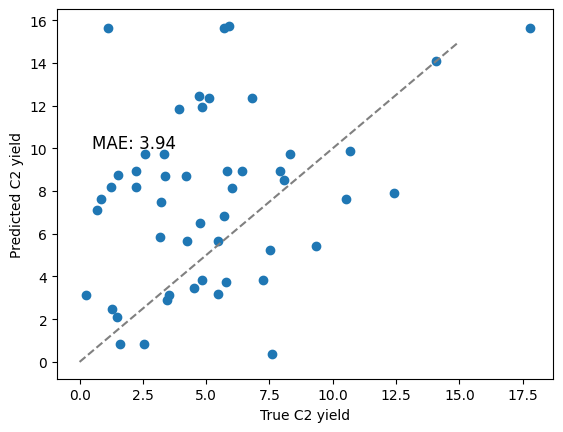

In [63]:
# print parity plot with y and yhat
import matplotlib.pyplot as plt
plt.scatter(
    np.array([yi['C2_yield'] for yi in y]).astype(float),
    np.array(yhat).astype(float), 
    )
plt.plot([0, 15], [0, 15], '--', color='gray')
plt.xlabel("True C2 yield")
plt.ylabel("Predicted C2 yield")
plt.text(0.5, 10, f"MAE: {-m:.2f}", fontsize=12)
plt.show()


In [ ]:
evaluate = Evaluate(devset=dev_dataset, metric=mae, num_threads=4, display_progress=True, display_table=0)
print(f"\nScores for {cot}:\n"
      # f"vanilla:  {evaluate(vanilla)}\n"
      # f"zeroshot: {evaluate(cot)}\n"
      f"fewshot:  {evaluate(fewshot)}\n"
      # f"bootstrap:{evaluate(bootstrap)}\n"
    )